In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import time
import os
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/hello world/iVIX'
os.chdir(path)
option_data = pd.read_csv('options.csv',index_col=0,encoding='GBK')
shibor = pd.read_csv('shibor.csv',index_col=0,encoding='GBK')
trade_date = pd.read_csv('tradeday.csv',encoding='GBK')
true_ivix = pd.read_csv('ivixx.csv',encoding='GBK')

In [3]:
shibor = shibor.reset_index().rename(columns = {"index":'date'})

In [4]:
option_data = option_data.reset_index().rename(columns = {"index":"trade_date"})

In [5]:
vix_date = "2015/3/26"

In [6]:
def basic_inf(vix_date):
    
    #获取计算VIX当天的所有期权
    vix_option_data = option_data[option_data['trade_date'] == vix_date].reset_index(drop = True)
    #找到期权所有的到期日
    vix_enddate = pd.to_datetime(vix_option_data['EXE_ENDDATE'].unique()).sort_values().strftime("%Y/%m/%d %H:%M")
    return vix_option_data,vix_enddate


In [7]:
#找到近月和次月的期权到期日
def find_near_next_enddate(vix_date):
    if (datetime.strptime(basic_inf(vix_date)[1][0],'%Y/%m/%d %H:%M') - datetime.strptime(vix_date,'%Y/%m/%d')).days < 5:
        near_term = 1
        next_term = 2
    else:
        near_term = 0
        next_term = 1
    return near_term,next_term
    

In [8]:
#对现有的shibor利率期限结构进行插值，计算得到相应的shibor
def vix_shibor(vix_date):
    periods = []
    for i in range(len(basic_inf(vix_date)[1])):
        period = (datetime.strptime(basic_inf(vix_date)[1][i],'%Y/%m/%d %H:%M')-datetime.strptime(vix_date,'%Y/%m/%d')).days/365
        periods.append(period)
    #利用现有的shibor期限结构，插值求出剩余期限下的shibor
    vix_date = datetime.strptime(vix_date,'%Y/%m/%d').strftime("%Y-%m-%d")
    fixed_shibor = np.asarray(shibor[shibor['date'] == vix_date].values[0].tolist()[1:])
    fixed_date = np.asarray([1, 7, 14, 30, 90, 180, 270, 360]) / 365
    vix_shibor = griddata(fixed_date, fixed_shibor, np.asarray(periods), method = 'linear')/100
    return vix_shibor,periods

In [9]:
#获取远期价格F
def future_price(option,shibor,tenor):
    call = option[option['EXE_MODE'].isin([u'认购'])].sort_values(by = ['EXE_PRICE']).reset_index(drop = True)
    put = option[option['EXE_MODE'].isin([u'认沽'])].sort_values(by = ['EXE_PRICE']).reset_index(drop = True)
    price_diff = abs(call['CLOSE']-put['CLOSE']).min()
    strike = call.loc[abs(call['CLOSE']-put['CLOSE']).idxmin(),'EXE_PRICE']
    future = strike + np.exp(shibor*tenor)*price_diff
    return future

In [10]:
#按照公式对期权的信进行处理
def sigma_component(x):
    return x['delta_K']*x['CLOSE']/(x['EXE_PRICE']**2)

In [11]:
def cal_square(option,future,shibor,tenor):
    #计算出离远期价格最近的行权价k0
    k0 = option[option['EXE_PRICE'] < future].max()['EXE_PRICE']
    
    #从K0隔开取出看涨和看跌虚值期权
    call = option[(option['EXE_MODE'].isin([u'认购'])) & (option['EXE_PRICE'] > k0)].sort_values(by = ['EXE_PRICE']).reset_index(drop = True)
    put = option[(option['EXE_MODE'].isin([u'认沽'])) & (option['EXE_PRICE'] <= k0)].sort_values(by = ['EXE_PRICE']).reset_index(drop = True)
    put.loc[len(put)-1,'CLOSE'] = option[option['EXE_PRICE'] == k0]['CLOSE'].sum()/2
    otm_option = pd.concat([put,call]).reset_index(drop = True)
    #计算delta_K
    otm_option['delta_K'] = 0.05
    
    if len(otm_option) < 3:
        otm_option['delta_K'] = otm_option['EXE_PRICE'].iloc[-1]-otm_option['EXE_PRICE'].iloc[0]
    else:
        otm_option.loc[0,'delta_K'] = otm_option.loc[1,'EXE_PRICE']-otm_option.loc[0,'EXE_PRICE']
        otm_option.loc[len(otm_option)-1,'delta_K'] = otm_option.loc[len(otm_option)-1,'EXE_PRICE']-otm_option.loc[len(otm_option)-2,'EXE_PRICE']
        for i in range(1,len(otm_option)-1):
            otm_option.loc[i,'delta_K'] = (otm_option.loc[i+1,'EXE_PRICE']-otm_option.loc[i-1,'EXE_PRICE'])/2
    
     #有bug,除数为零，调试至.sum()，
    sigma = otm_option.apply(lambda x:sigma_component(x),axis = 1).sum()*(np.exp(shibor*tenor))*(2/tenor) #-(((future/k0)-1)**2)/tenor
 
    return sigma 

In [12]:
def calDayVIX(vix_date):
    #计算近月和次近月期权的剩余期限
    near_tenor = vix_shibor(vix_date)[1][find_near_next_enddate(vix_date)[0]]
    next_tenor = vix_shibor(vix_date)[1][find_near_next_enddate(vix_date)[1]]

    #计算近月和次近月期权剩余期限对应下的利率
    near_shibor = vix_shibor(vix_date)[0].tolist()[find_near_next_enddate(vix_date)[0]]
    next_shibor = vix_shibor(vix_date)[0].tolist()[find_near_next_enddate(vix_date)[1]]

    #获取近月和次近月的所有期权
    near_option = basic_inf(vix_date)[0][ pd.to_datetime(basic_inf(vix_date)[0]['EXE_ENDDATE']) == pd.to_datetime(basic_inf(vix_date)[1][find_near_next_enddate(vix_date)[0]])].reset_index(drop = True)
    next_option = basic_inf(vix_date)[0][ pd.to_datetime(basic_inf(vix_date)[0]['EXE_ENDDATE']) == pd.to_datetime(basic_inf(vix_date)[1][find_near_next_enddate(vix_date)[1]])].reset_index(drop = True)

    #获取近月和次近月的远期价格F
    near_future = future_price(near_option,near_shibor,near_tenor)
    next_future = future_price(next_option,next_shibor,next_tenor)
    
    #获取近月和次近月期权的sigma
    near_sigma = cal_square(near_option,near_future,near_shibor,near_tenor)
    next_sigma = cal_square(next_option,next_future,next_shibor,next_tenor)
    
    ivix = np.sqrt((near_tenor*(near_sigma)*((next_tenor-30/365)/(next_tenor-near_tenor))+next_tenor*(next_sigma)*((30/365-near_tenor)/(next_tenor-near_tenor)))*(365/30))*100
    
    return ivix

In [13]:
calDayVIX(vix_date)

26.374143944440043

In [14]:
df = pd.DataFrame({"day":trade_date["DateTime"].tolist()})

In [15]:
df["ivix"] = df["day"].apply(calDayVIX)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     829 non-null    object 
 1   ivix    829 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.1+ KB


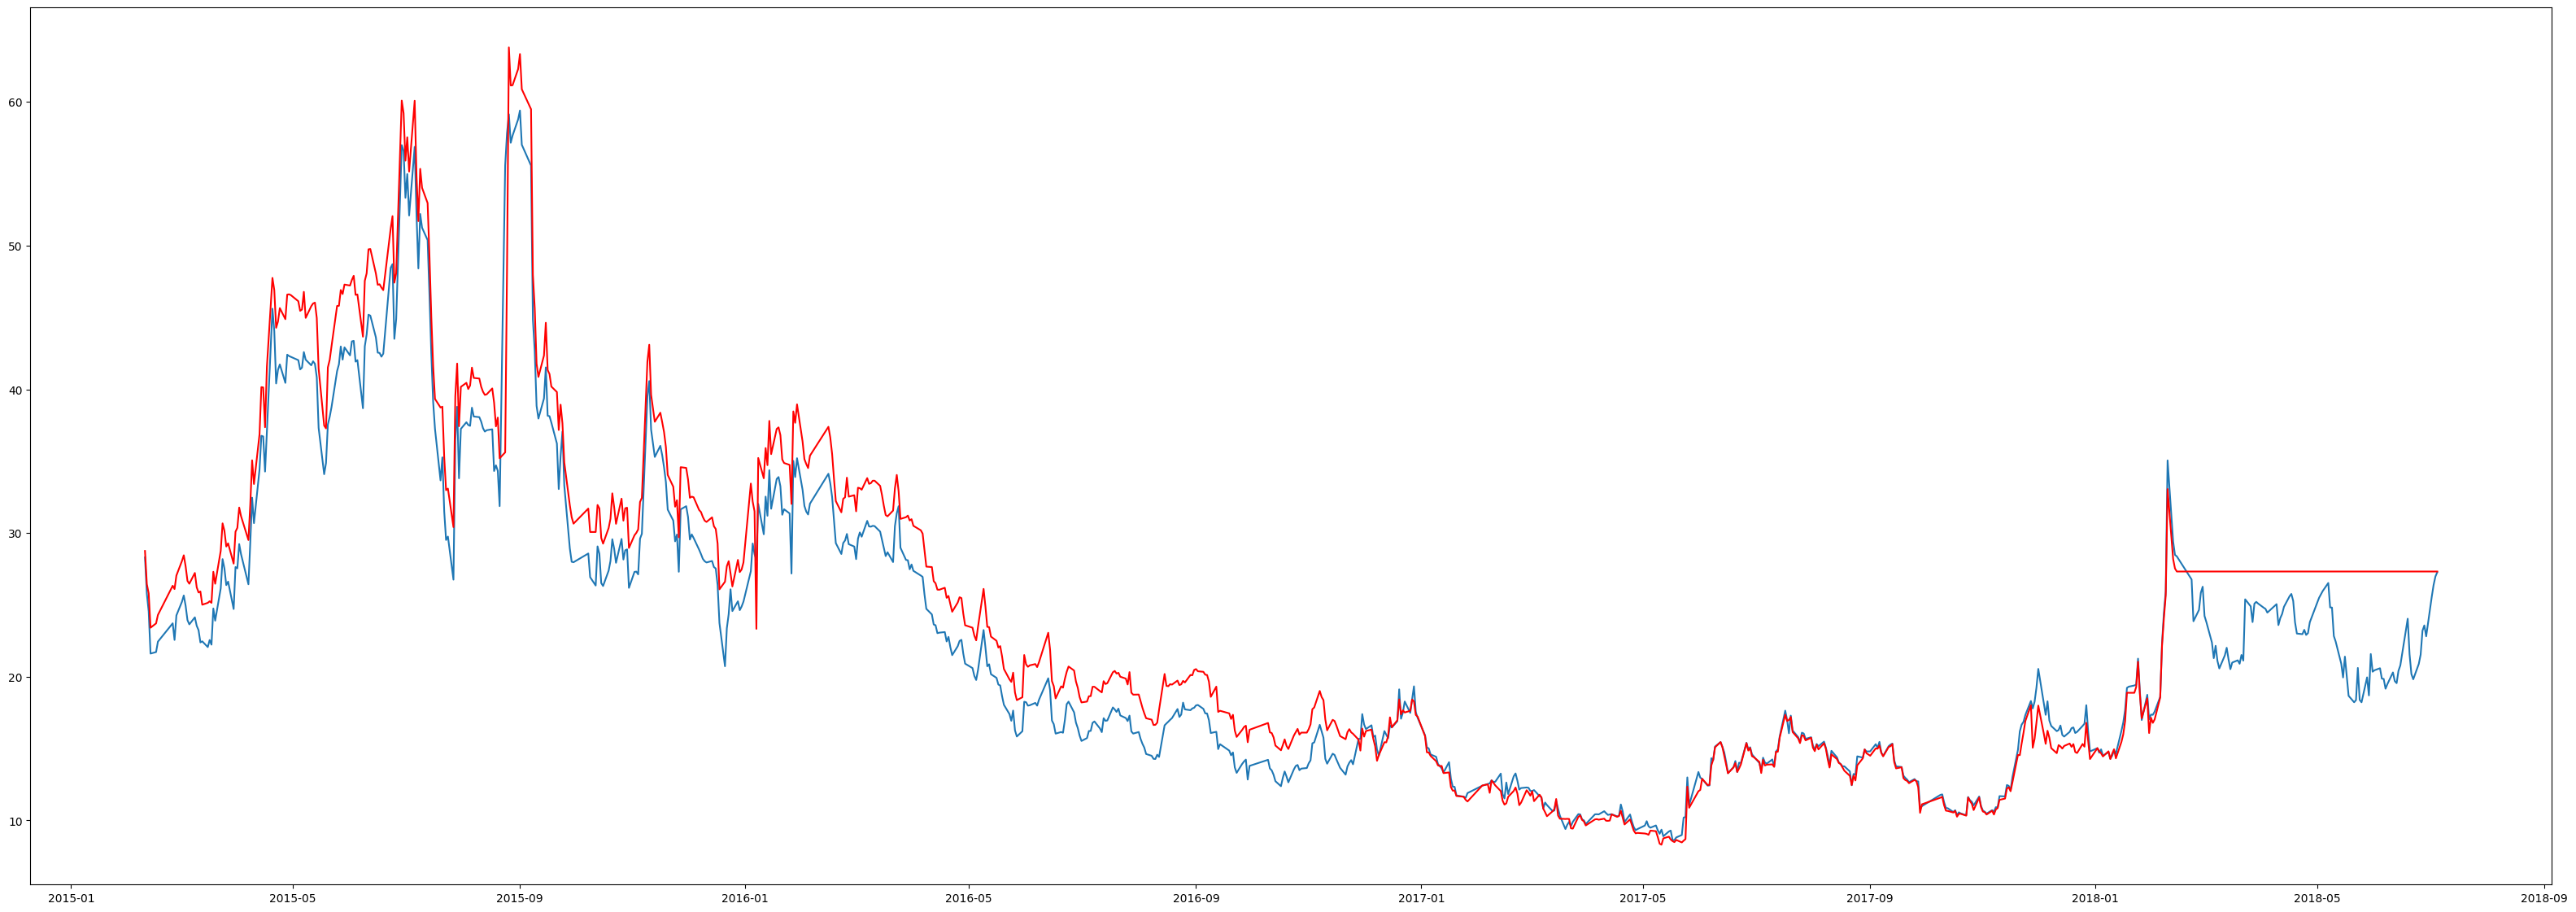

In [17]:
fig,ax = plt.subplots(figsize=(40,14))
ax.plot(pd.to_datetime(df.day),df.ivix)
ax.plot(pd.to_datetime(df.day),true_ivix[u'收盘价(元)'].tolist(),color = "r")
plt.show()